In [117]:
import os

import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [130]:
df = pd.read_csv("./Data/babyweight_sample.csv") 
df.plurality.head(5)
df.describe()

,weight_pounds,mother_age,gestation_weeks
count,999.000000,999.000000,999.000000
mean,4.236444,29.446446,30.708709
std,2.361471,14.561489,6.952187
min,0.500449,12.000000,17.000000
25%,2.186986,15.000000,27.000000
50%,3.624400,42.000000,30.000000
75%,6.437498,43.000000,31.000000
max,11.062796,52.000000,47.000000


In [119]:
CLASSES = {
    'Single(1)': 0,
    'Multiple(2+)': 1,
    'Twins(2)': 2,
    'Triplets(3)': 3,
    'Quadruplets(4)': 4,
    'Quintuplets(5)': 5
}
N_CLASSES = len(CLASSES)

In [120]:
plurality_class = [CLASSES[plurality] for plurality in df.plurality]
"""
Here, CLASSES is a Python dictionary mapping string labels to integer codes. The expression CLASSES[plurality]
uses the dictionary lookup operator [...] to retrieve the value associated with the key held in the variable plurality.
– If plurality == 'Twins(2)', then CLASSES[plurality] returns 2.
– If the key isn’t in the dictionary, you’d get a KeyError.
"""
print(plurality_class)

[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 1, 0, 

In [132]:
EMBED_DIM = 2 # This defines that each category will be mapped to a 2-dimensional vector. We're going from 6 classes to 2 dimensions.

embedding_layer = layers.Embedding(input_dim=N_CLASSES, # input_dim=N_CLASSES (which is 6): Tells the layer to expect integer inputs from 0 to 5
                                   output_dim=EMBED_DIM) # output_dim=EMBED_DIM (which is 2): Each integer will be mapped to a 2D vector

# Think of this as creating a lookup table
"""
Index 0 (Single)      → [random_value1, random_value2]
Index 1 (Multiple)    → [random_value3, random_value4]
Index 2 (Twins)       → [random_value5, random_value6]
Index 3 (Triplets)    → [random_value7, random_value8]
Index 4 (Quadruplets) → [random_value9, random_value10]
Index 5 (Quintuplets) → [random_value11, random_value12]
"""
embeds = embedding_layer(tf.constant(plurality_class)) # Applying the Embedding
""" 
- plurality_class is a list like [0, 2, 1, 0, 3, ...] (the integer codes for each sample)
- tf.constant() converts it to a TensorFlow tensor
- The embedding layer looks up each integer and returns its corresponding 2D vector
"""

In [128]:
embeds.shape

TensorShape([999, 2])

In [129]:
""" This is the simplest form of embeddings where
1. Lookup Table: The embedding layer creates a weight matrix of shape (6, 2) - essentially a lookup table
2. Random Initialization: The embedding vectors start with random values
3. Learned During Training: These vectors are updated through backpropagation during model training
"""
embeds[:5]
# Output the first 5 embeddings

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.02642489,  0.04549296],
       [ 0.02642489,  0.04549296],
       [ 0.02642489,  0.04549296],
       [ 0.01094618, -0.01568002],
       [ 0.02642489,  0.04549296]], dtype=float32)>

In [85]:
print(embedding_layer.weights)

[<Variable path=embedding_5/embeddings, shape=(6, 2), dtype=float32, value=[[-0.00551952 -0.03363969]
 [ 0.04656968 -0.04476753]
 [-0.00456963  0.04211232]
 [ 0.0064072  -0.02775153]
 [ 0.0025609  -0.01577356]
 [ 0.0153077   0.01007269]]>]


## Text embedding

In [140]:
# Task: predict which website an article comes from based on its title
LOGDIR = "./text_models"
DATA_DIR = "./Data"

In [138]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['title', 'source']   # load the 2 columns of the dataset into a DataFrame with key names 'title' and 'source'

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head(100)

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github
...,...,...
95,cooper union s free tuition tradition may be ...,nytimes
96,htmly databaseless blogging platform flat-fi...,github
97,a lightweight javaweb framework concise and p...,github
98,transcription of dybvig s simple scheme interp...,github


In [159]:
tokenizer = Tokenizer() # Tokenizer creates a vocabulary mapping words → integers
tokenizer.fit_on_texts(titles_df.title) # fit_on_texts() builds the vocabulary from all titles
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)  # texts_to_sequences() converts each title to a list of integers

In [160]:
integerized_titles[:3]

[[6117, 560, 8577, 13948, 302, 13, 172],
 [11, 12, 2, 49, 7, 3838, 1322, 91, 4, 28, 482],
 [11, 12, 1501, 2812, 322, 5, 589, 7337, 5458, 78, 108, 1989, 17, 1139]]

In [157]:
token_id = integerized_titles[0][0]
word = tokenizer.index_word[token_id]         # maps ID → word
print(f"{token_id} → {word}")

# to decode a full sequence back into words:
decoded = [tokenizer.index_word[id] for id in integerized_titles[0]]  # this create a list of words from the first title's integerized sequence
print(decoded)

3 → nytimes
['nytimes']


In [90]:
VOCAB_SIZE = len(tokenizer.index_word) # Total unique words
VOCAB_SIZE

47271

In [139]:
DATASET_SIZE = tokenizer.document_count # Total number of titles
DATASET_SIZE

96203

In [161]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles) # Longest title
MAX_LEN

26

In [93]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,
                                     max_len,
                                     padding='post')
    return padded_sequences
""" IMPORTANT NOTE:
Neural networks need fixed-size inputs
pad_sequences() adds zeros to make all sequences the same length
padding='post' adds zeros at the end
"""

In [94]:
sample_titles = create_sequences(["holy cash cow  batman - content is back",
                                 "close look at a flu outbreak upends some common wisdom"])
sample_titles

array([[ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1030,   316,    23,     2,  3718,  7338, 13949,   214,   715,
         4581,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [95]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [96]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = utils.to_categorical(classes)
    return one_hots

""" 
Converts source labels to one-hot vectors:
'github' → [1, 0, 0]
'nytimes' → [0, 1, 0]
'techcrunch' → [0, 0, 1]
"""

In [172]:
# Determine how many samples to use for training (80% of the total dataset)
N_TRAIN = int(DATASET_SIZE * 0.8)
print("Number of training samples: " + str(N_TRAIN))

# Load the CSV of titles and sources into a DataFrame
# – header=None    : the file has no header row
# – names=COLUMNS : assign our ['title', 'source'] column names
titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)

# Slice out the first N_TRAIN rows for the training split
# – titles_train  : the text inputs (titles) for training
# – sources_train : the labels (source names) for training
titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN]
)

# Slice the remaining rows for validation
# – titles_valid  : the text inputs for validation
# – sources_valid : the labels for validation
titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:]
)

Number of training samples: 76962


In [98]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [162]:
	
def build_dnn_model(embed_dim):

    model = models.Sequential([
        # Embedding Layer:
        #   Input:  (batch_size, MAX_LEN)         — sequences of word indices
        #   Output: (batch_size, MAX_LEN, embed_dim) — sequences of dense vectors
        #   Learns a lookup table mapping each word index → embed_dim-length vector
        layers.Embedding(VOCAB_SIZE + 1,
                         embed_dim,
                         input_shape=[MAX_LEN]),

        # Lambda Layer (Average Pooling):
        #   Input:  (batch_size, MAX_LEN, embed_dim)
        #   Output: (batch_size, embed_dim)
        #   Averages over the time dimension to get one fixed-size vector per sample
        layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),

        # Dense Layer:
        #   Input:  (batch_size, embed_dim)
        #   Output: (batch_size, N_CLASSES)
        #   Softmax activation to produce a probability distribution over classes
        layers.Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',                 # Adam optimizer
        loss='categorical_crossentropy',  # loss for multi-class classification
        metrics=['accuracy']              # track accuracy during training
    )
    return model

In [164]:
titles_train[0], X_train[0], Y_train[0], sources_train[0]

('holy cash cow  batman - content is back',
 array([ 6117,   560,  8577, 13948,   302,    13,   172,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       dtype=int32),
 array([0., 1., 0.]),
 'nytimes')

Epoch 1/100


/home/trungthieu/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4027 - loss: 1.0625 - val_accuracy: 0.6632 - val_loss: 0.9240
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6856 - loss: 0.8744 - val_accuracy: 0.7598 - val_loss: 0.7510
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7694 - loss: 0.7174 - val_accuracy: 0.7899 - val_loss: 0.6451
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7998 - loss: 0.6159 - val_accuracy: 0.8049 - val_loss: 0.5709
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8180 - loss: 0.5420 - val_accuracy: 0.8174 - val_loss: 0.5176
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8322 - loss: 0.4874 - val_accuracy: 0.8248 - val_loss: 0.4792
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8437 - loss: 0.4464 - val_accuracy: 0.8316 - val_loss: 0.4511
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8523 - loss: 0.4146 - val_accuracy: 0.8370

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 26, 10)         │       472,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,418,261 (5.41 MB)

 Trainable params: 472,753 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 945,508 (3.61 MB)

CPU times: user 25.2 s, sys: 22.5 s, total: 47.8 s
Wall time: 15.9 s


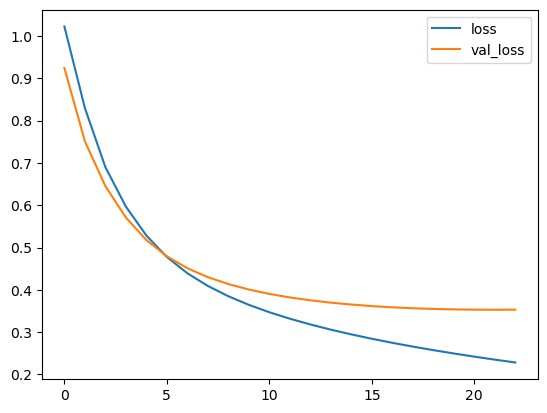

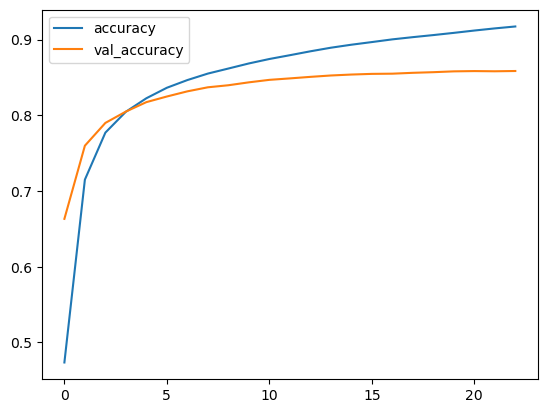

In [101]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
#shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[callbacks.EarlyStopping(patience=PATIENCE),
               callbacks.TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()